# EuroSat Image Classification using MaxVit

Hector Becerra  
Juan Terven  
2023

MaxViT is an efficient and scalable attention model called multi-axis attention, which consists of two aspects: blocked local and dilated global attention. These design choices allow global-local spatial interactions on arbitrary input resolutions with only linear complexity. MaxViT blends the attention model with convolutions, in a simple hierarchical vision backbone, dubbed MaxViT, by simply repeating the basic building block over multiple stages. Notably, MaxViT is able to see globally throughout the entire network, even in earlier, high-resolution stages. The results demonstrate the effectiveness of the model on a broad spectrum of vision tasks. On image classification, MaxViT achieves state-of-the-art performance under various settings: without extra data, MaxViT attains 86.5% ImageNet-1K top-1 accuracy; with ImageNet-21K pre-training, our model achieves 88.7% top-1 accuracy.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import maxvit_t,MaxVit_T_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.13.1+cu117


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_ResNeXt_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "C:/Users/jrtervens/Documents/data/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Check the transformations used in the pre-trained model
weights = MaxVit_T_Weights.DEFAULT
preprocess = weights.transforms()
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [7]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((224,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((224, 224)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 32  # The batch size for training data.
val_batch = 8     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

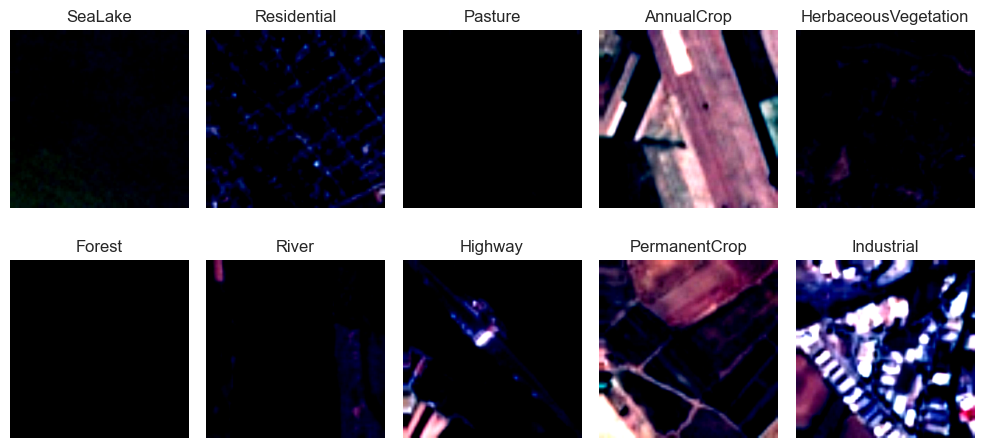

In [9]:
visualize_classes(train_loader, index_to_label)

In [10]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 591
Validation set batches: 675
Test set examples: 2700


## Labels distribution

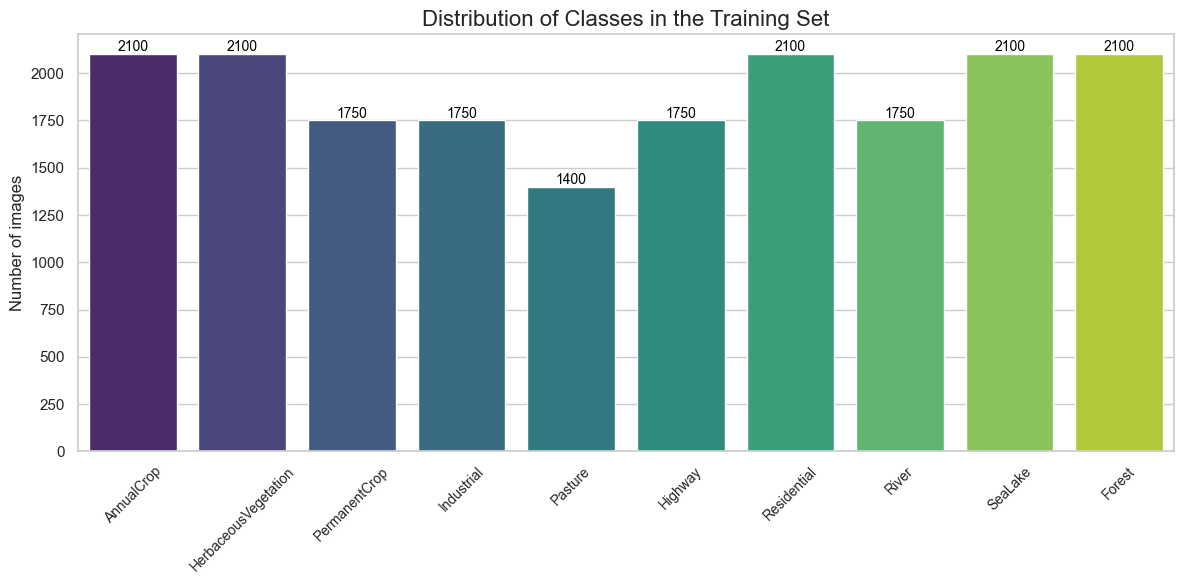

In [11]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [12]:
# Use un-pretrained model
model = maxvit_t()

# Replace the model head with the number of classes
num_classes = 10
model.classifier[5] = nn.Linear(512, num_classes) 
model.to(DEVICE)

C:\Users\jrtervens\.conda\envs\pytorch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

# Training model from Scratch

In [13]:
project_name = "EuroSAT"
model_name = "MaxViT"
models_path = "C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models"

In [25]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="MaxViT from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 model_name=model_name,
                                 lr=lr, patience=patience,
                                 device=DEVICE,
                                 model_save_path=models_path)

Starting training with early stopping patience of 10
Each epoch has 591 steps.

Epoch: 1...
Step: 21/591 Loss: 1.8906785190105437
Step: 41/591 Loss: 1.699807196855545
Step: 61/591 Loss: 1.374949386715889
Step: 81/591 Loss: 1.3814760863780975
Step: 101/591 Loss: 1.2705477058887482
Step: 121/591 Loss: 1.2639462143182754
Step: 141/591 Loss: 1.176205050945282
Step: 161/591 Loss: 1.1441020339727401
Step: 181/591 Loss: 1.1279833644628525
Step: 201/591 Loss: 1.1359122544527054
Step: 221/591 Loss: 1.0006293386220932
Step: 241/591 Loss: 1.1705500692129136
Step: 261/591 Loss: 1.0224004834890366
Step: 281/591 Loss: 0.9861692726612091
Step: 301/591 Loss: 1.0482334285974502
Step: 321/591 Loss: 1.0462863266468048
Step: 341/591 Loss: 1.0744825065135957
Step: 361/591 Loss: 0.9933144509792328
Step: 381/591 Loss: 0.8404391765594482
Step: 401/591 Loss: 0.8614612132310867
Step: 421/591 Loss: 0.9484413087368011
Step: 441/591 Loss: 0.7889108896255493
Step: 461/591 Loss: 0.8664400443434715
Step: 481/591 Loss

Step: 401/591 Loss: 0.21106838984414936
Step: 421/591 Loss: 0.24554415168240667
Step: 441/591 Loss: 0.1880219081416726
Step: 461/591 Loss: 0.18216775851324202
Step: 481/591 Loss: 0.1558542488142848
Step: 501/591 Loss: 0.15519217466935514
Step: 521/591 Loss: 0.19506771294400096
Step: 541/591 Loss: 0.17981621585786342
Step: 561/591 Loss: 0.1817449640482664
Step: 581/591 Loss: 0.1510803308337927
Validation Loss: 0.1796 Accuracy: 0.9415
Best model saved.
Epoch duration: 238.26s

Epoch: 8...
Step: 21/591 Loss: 0.09430123437196017
Step: 41/591 Loss: 0.13581791399046778
Step: 61/591 Loss: 0.11600700872950256
Step: 81/591 Loss: 0.13501960667781532
Step: 101/591 Loss: 0.15058437446132303
Step: 121/591 Loss: 0.11645645992830396
Step: 141/591 Loss: 0.15382946077734233
Step: 161/591 Loss: 0.1609276772942394
Step: 181/591 Loss: 0.13760070521384477
Step: 201/591 Loss: 0.11450056112371385
Step: 221/591 Loss: 0.11091954833827913
Step: 241/591 Loss: 0.17102466383948922
Step: 261/591 Loss: 0.13987520975

Step: 181/591 Loss: 0.08015227299183607
Step: 201/591 Loss: 0.14355771741829812
Step: 221/591 Loss: 0.11291318314615637
Step: 241/591 Loss: 0.078482147725299
Step: 261/591 Loss: 0.12413029870949685
Step: 281/591 Loss: 0.10080103939399124
Step: 301/591 Loss: 0.060375006613321604
Step: 321/591 Loss: 0.06304919491522014
Step: 341/591 Loss: 0.0823477828875184
Step: 361/591 Loss: 0.07966033384436741
Step: 381/591 Loss: 0.08334087573457509
Step: 401/591 Loss: 0.0863112045219168
Step: 421/591 Loss: 0.08321067085489631
Step: 441/591 Loss: 0.09643127925228327
Step: 461/591 Loss: 0.08172228832263499
Step: 481/591 Loss: 0.09375213393941521
Step: 501/591 Loss: 0.05933111128397286
Step: 521/591 Loss: 0.03666624440811574
Step: 541/591 Loss: 0.05881657649297267
Step: 561/591 Loss: 0.08240276754368096
Step: 581/591 Loss: 0.08383317335974425
Validation Loss: 0.1605 Accuracy: 0.9504
Epoch duration: 237.24s

Epoch: 15...
Step: 21/591 Loss: 0.0519604726228863
Step: 41/591 Loss: 0.041342784208245574
Step: 

Step: 581/591 Loss: 0.0802641632850282
Validation Loss: 0.1415 Accuracy: 0.9583
Epoch duration: 237.92s

Epoch: 21...
Step: 21/591 Loss: 0.04127550120465458
Step: 41/591 Loss: 0.07069993686163797
Step: 61/591 Loss: 0.06190194098744541
Step: 81/591 Loss: 0.0664475249737734
Step: 101/591 Loss: 0.05942791323177517
Step: 121/591 Loss: 0.038196291262283924
Step: 141/591 Loss: 0.06579945234698244
Step: 161/591 Loss: 0.07122421780368313
Step: 181/591 Loss: 0.0556393196224235
Step: 201/591 Loss: 0.054048990039154886
Step: 221/591 Loss: 0.03992090378887951
Step: 241/591 Loss: 0.033244584262138235
Step: 261/591 Loss: 0.04977075972710736
Step: 281/591 Loss: 0.09965952743659727
Step: 301/591 Loss: 0.05906146733323112
Step: 321/591 Loss: 0.05087663799058646
Step: 341/591 Loss: 0.038967788557056335
Step: 361/591 Loss: 0.06386175468796865
Step: 381/591 Loss: 0.12538895934121683
Step: 401/591 Loss: 0.07306907521560788
Step: 421/591 Loss: 0.08137590419501066
Step: 441/591 Loss: 0.0584738988080062
Step:

Step: 321/591 Loss: 0.020925149525282905
Step: 341/591 Loss: 0.019940346432849764
Step: 361/591 Loss: 0.04071211748232599
Step: 381/591 Loss: 0.021460927737643944
Step: 401/591 Loss: 0.034097896388266234
Step: 421/591 Loss: 0.0469439425971359
Step: 441/591 Loss: 0.02317020549235167
Step: 461/591 Loss: 0.025091462736600078
Step: 481/591 Loss: 0.05453948854992632
Step: 501/591 Loss: 0.04896963107748888
Step: 521/591 Loss: 0.04067329444515053
Step: 541/591 Loss: 0.07691140801180155
Step: 561/591 Loss: 0.039351668953895566
Step: 581/591 Loss: 0.05638161051319912
Validation Loss: 0.1391 Accuracy: 0.9593
Epoch duration: 243.55s

Epoch: 28...
Step: 21/591 Loss: 0.06584771390771493
Step: 41/591 Loss: 0.02667673354735598
Step: 61/591 Loss: 0.0415145190723706
Step: 81/591 Loss: 0.027417595795122908
Step: 101/591 Loss: 0.018435207448783332
Step: 121/591 Loss: 0.02492679129354656
Step: 141/591 Loss: 0.011948024318553508
Step: 161/591 Loss: 0.012447200826136396
Step: 181/591 Loss: 0.029219229123555

In [26]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as file:
    file.write(f"loss_i: {loss_i}\n")
    file.write(f"loss_val_i: {loss_val_i}\n")

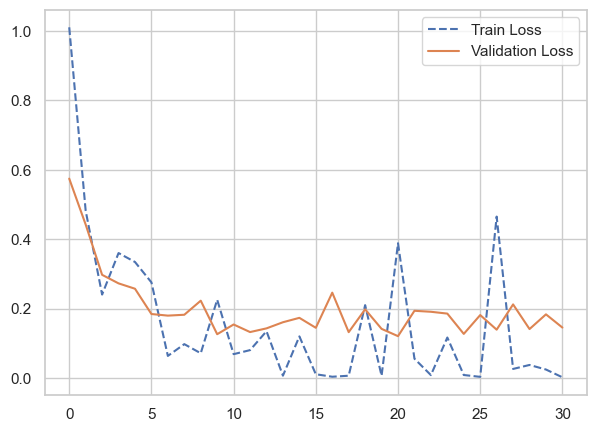

In [27]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

## Load best trained model

In [14]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = os.path.join(models_path, f"{model_name}_best_model.pth")
print(f"Loading {model_save_path}")
model.load_state_dict(torch.load(f = model_save_path))

Loading C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\MaxViT_best_model.pth


<All keys matched successfully>

In [29]:
# Call this function before evaluating your model to remove any wandb hook if needed
#remove_wandb_hooks(model)

In [15]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.954     0.973     0.964       300
              Forest      0.997     0.993     0.995       300
HerbaceousVegetation      0.953     0.950     0.952       300
             Highway      0.961     0.988     0.974       250
          Industrial      0.992     0.976     0.984       250
             Pasture      0.949     0.940     0.945       200
       PermanentCrop      0.933     0.940     0.936       250
         Residential      1.000     0.997     0.998       300
               River      0.984     0.960     0.972       250
             SeaLake      0.997     0.997     0.997       300

            accuracy                          0.973      2700
           macro avg      0.972     0.971     0.972      2700
        weighted avg      0.973     0.973     0.973      2700



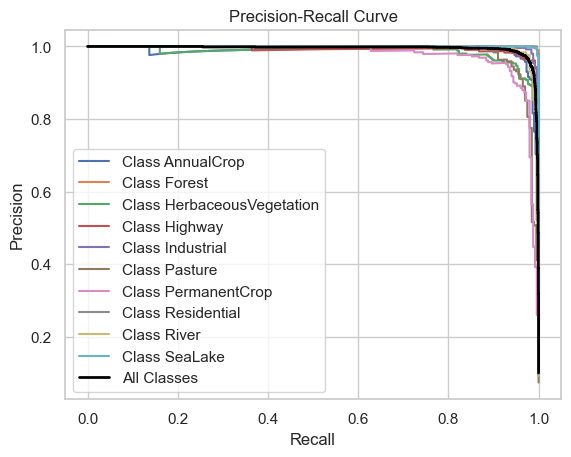

In [31]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [32]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇▆█▇██▇▇█▇█▇██▇▇▇█▇█▇███
val_loss,█▆▄▃▃▂▂▂▃▁▂▁▁▂▂▁▃▁▂▁▁▂▂▂▁▂▁▂▁▂▁
epoch,30
step,18310
train_loss,0.02532
val_accuracy,0.95981
val_loss,0.14519


## Load the precision/recall curve and plot it

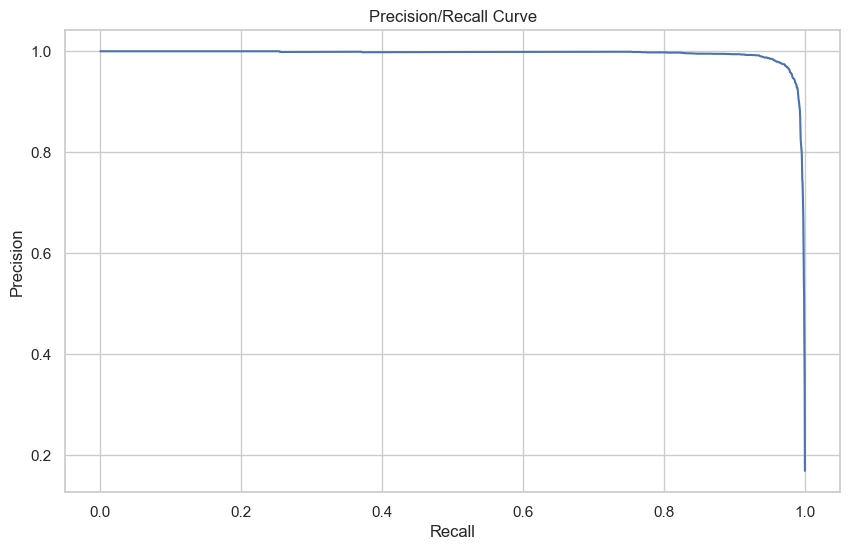

In [33]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [16]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


26970

# Now train the model with pre-trained weights

In [17]:
# Use pretrained model
model2 = maxvit_t(weights=MaxVit_T_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.classifier[5] = nn.Linear(512, num_classes) 
model2.to(DEVICE)

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

## Train with pre-trained weights

In [18]:
model_name = "MaxViT-Pretrained"

In [36]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="MaxViT pre-trained on ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 model_name=model_name,
                                 lr=lr, patience=patience,
                                 device=DEVICE,
                                 model_save_path=models_path
                                )

Starting training with early stopping patience of 10
Each epoch has 591 steps.

Epoch: 1...
Step: 21/591 Loss: 1.9660572946071624
Step: 41/591 Loss: 1.1260866552591324
Step: 61/591 Loss: 0.6295806631445885
Step: 81/591 Loss: 0.3806160666048527
Step: 101/591 Loss: 0.27190640941262245
Step: 121/591 Loss: 0.23021002300083637
Step: 141/591 Loss: 0.19337407164275647
Step: 161/591 Loss: 0.1570115752518177
Step: 181/591 Loss: 0.16557664107531309
Step: 201/591 Loss: 0.14290726669132708
Step: 221/591 Loss: 0.19033034890890121
Step: 241/591 Loss: 0.1233419494703412
Step: 261/591 Loss: 0.16764775272458793
Step: 281/591 Loss: 0.1033807596191764
Step: 301/591 Loss: 0.12270013326779008
Step: 321/591 Loss: 0.10603029755875468
Step: 341/591 Loss: 0.10671999752521515
Step: 361/591 Loss: 0.13873803531751036
Step: 381/591 Loss: 0.12168780006468297
Step: 401/591 Loss: 0.12433278830721975
Step: 421/591 Loss: 0.08647346636280417
Step: 441/591 Loss: 0.08652228256687522
Step: 461/591 Loss: 0.10530943828634917

Step: 321/591 Loss: 0.014613248864770867
Step: 341/591 Loss: 0.01762499229516834
Step: 361/591 Loss: 0.041011977463494984
Step: 381/591 Loss: 0.017383681563660502
Step: 401/591 Loss: 0.022907147780642845
Step: 421/591 Loss: 0.017980746098328382
Step: 441/591 Loss: 0.03949729489395395
Step: 461/591 Loss: 0.05977088138461113
Step: 481/591 Loss: 0.0361984180228319
Step: 501/591 Loss: 0.02485448003571946
Step: 521/591 Loss: 0.04175826277642045
Step: 541/591 Loss: 0.048303010687232015
Step: 561/591 Loss: 0.05584962441353127
Step: 581/591 Loss: 0.04307324367109686
Validation Loss: 0.0490 Accuracy: 0.9856
Best model saved.
Epoch duration: 239.08s

Epoch: 8...
Step: 21/591 Loss: 0.007392290519783273
Step: 41/591 Loss: 0.007474992313655093
Step: 61/591 Loss: 0.00671643536479678
Step: 81/591 Loss: 0.0033479079545941206
Step: 101/591 Loss: 0.002419432028545998
Step: 121/591 Loss: 0.0022884398145833983
Step: 141/591 Loss: 0.00194683292938862
Step: 161/591 Loss: 0.0024199315041187218
Step: 181/591 

Validation Loss: 0.1791 Accuracy: 0.9606
Epoch duration: 238.46s

Epoch: 14...
Step: 21/591 Loss: 0.03611688442906598
Step: 41/591 Loss: 0.027109071351151214
Step: 61/591 Loss: 0.032408167245739604
Step: 81/591 Loss: 0.01426243975001853
Step: 101/591 Loss: 0.0318364134116564
Step: 121/591 Loss: 0.041520520416088405
Step: 141/591 Loss: 0.03819780947524123
Step: 161/591 Loss: 0.036487654916709286
Step: 181/591 Loss: 0.02640632713882951
Step: 201/591 Loss: 0.028919134251191282
Step: 221/591 Loss: 0.09867141622235068
Step: 241/591 Loss: 0.053096013888716695
Step: 261/591 Loss: 0.06810347344726324
Step: 281/591 Loss: 0.028489007649477573
Step: 301/591 Loss: 0.02751769355381839
Step: 321/591 Loss: 0.04752443872857839
Step: 341/591 Loss: 0.014730016954126767
Step: 361/591 Loss: 0.01098777741426602
Step: 381/591 Loss: 0.024049935929360798
Step: 401/591 Loss: 0.02618155372911133
Step: 421/591 Loss: 0.01933247491833754
Step: 441/591 Loss: 0.016420127495075577
Step: 461/591 Loss: 0.01519600659667

Step: 261/591 Loss: 0.0035893911837774793
Step: 281/591 Loss: 0.0011958308881730773
Step: 301/591 Loss: 0.0006959287435165607
Step: 321/591 Loss: 0.0035983612651762087
Step: 341/591 Loss: 0.0011554152762982995
Step: 361/591 Loss: 0.001272350939689204
Step: 381/591 Loss: 0.0006059487684979103
Step: 401/591 Loss: 0.002073571925575379
Step: 421/591 Loss: 0.0013693344299099408
Step: 441/591 Loss: 0.0017586029760423116
Step: 461/591 Loss: 0.002931659029854927
Step: 481/591 Loss: 0.0032798771408124594
Step: 501/591 Loss: 0.0015325949709222187
Step: 521/591 Loss: 0.00044088298636779655
Step: 541/591 Loss: 0.000268307404985535
Step: 561/591 Loss: 0.000322232678081491
Step: 581/591 Loss: 0.00023646053195989226
Validation Loss: 0.0510 Accuracy: 0.9878
Epoch duration: 241.12s

Epoch: 21...
Step: 21/591 Loss: 0.00017378689044562635
Step: 41/591 Loss: 0.0001663892366195796
Step: 61/591 Loss: 0.000237813669082243
Step: 81/591 Loss: 0.00016070860256149898
Step: 101/591 Loss: 0.00020829243840125855
St

Step: 441/591 Loss: 2.4428311917290557e-05
Step: 461/591 Loss: 2.5512088359391783e-05
Step: 481/591 Loss: 2.5589469169062794e-05
Step: 501/591 Loss: 2.4755373033258365e-05
Step: 521/591 Loss: 2.3794277149136177e-05
Step: 541/591 Loss: 2.2518946389027404e-05
Step: 561/591 Loss: 2.3044386034598573e-05
Step: 581/591 Loss: 2.5195812577294417e-05
Validation Loss: 0.0543 Accuracy: 0.9898
Epoch duration: 248.38s

Epoch: 27...
Step: 21/591 Loss: 2.4240489619842264e-05
Step: 41/591 Loss: 2.3985817006177967e-05
Step: 61/591 Loss: 2.0821511134272443e-05
Step: 81/591 Loss: 2.1704931896238122e-05
Step: 101/591 Loss: 2.6062470351462252e-05
Step: 121/591 Loss: 2.269659235025756e-05
Step: 141/591 Loss: 2.3833012983232037e-05
Step: 161/591 Loss: 2.1480597843037687e-05
Step: 181/591 Loss: 2.1643472973664756e-05
Step: 201/591 Loss: 2.2064559470891253e-05
Step: 221/591 Loss: 1.976749026653124e-05
Step: 241/591 Loss: 1.9554277969291434e-05
Step: 261/591 Loss: 2.1008228168284403e-05
Step: 281/591 Loss: 1.92

Step: 21/591 Loss: 4.829251133742219e-06
Step: 41/591 Loss: 4.5195041252554805e-06
Step: 61/591 Loss: 4.597169515818678e-06
Step: 81/591 Loss: 4.409982022934855e-06
Step: 101/591 Loss: 4.560666275210678e-06
Step: 121/591 Loss: 4.455244459222741e-06
Step: 141/591 Loss: 4.414073725911294e-06
Step: 161/591 Loss: 4.231542538946087e-06
Step: 181/591 Loss: 4.0516101535104095e-06
Step: 201/591 Loss: 4.1732408362804564e-06
Step: 221/591 Loss: 4.436600215740328e-06
Step: 241/591 Loss: 3.903161132257082e-06
Step: 261/591 Loss: 3.929798424451292e-06
Step: 281/591 Loss: 3.932217077817768e-06
Step: 301/591 Loss: 4.000573653684114e-06
Step: 321/591 Loss: 4.422503081968898e-06
Step: 341/591 Loss: 3.7196930179561606e-06
Step: 361/591 Loss: 3.809282532074576e-06
Step: 381/591 Loss: 3.709633358539577e-06
Step: 401/591 Loss: 3.856594298667915e-06
Step: 421/591 Loss: 3.544417450029869e-06
Step: 441/591 Loss: 3.765881194794929e-06
Step: 461/591 Loss: 3.5341735497240735e-06
Step: 481/591 Loss: 3.68932936680

Step: 201/591 Loss: 7.318330489169967e-07
Step: 221/591 Loss: 8.089441479341985e-07
Step: 241/591 Loss: 7.539984864024518e-07
Step: 261/591 Loss: 7.335092988114412e-07
Step: 281/591 Loss: 7.161867756622087e-07
Step: 301/591 Loss: 7.353717137448257e-07
Step: 321/591 Loss: 7.117164244618834e-07
Step: 341/591 Loss: 7.204708310837305e-07
Step: 361/591 Loss: 6.677580273617422e-07
Step: 381/591 Loss: 6.93834991238873e-07
Step: 401/591 Loss: 6.381420575962693e-07
Step: 421/591 Loss: 6.522981607304245e-07
Step: 441/591 Loss: 6.368382202026623e-07
Step: 461/591 Loss: 6.254760393176184e-07
Step: 481/591 Loss: 6.290150366794478e-07
Step: 501/591 Loss: 6.251033582316267e-07
Step: 521/591 Loss: 6.219370163762505e-07
Step: 541/591 Loss: 5.846841645507084e-07
Step: 561/591 Loss: 5.992127512399747e-07
Step: 581/591 Loss: 6.094572910342322e-07
Validation Loss: 0.0811 Accuracy: 0.9896
Epoch duration: 247.32s

Epoch: 40...
Step: 21/591 Loss: 6.081534507984543e-07
Step: 41/591 Loss: 5.623323460213214e-07


KeyboardInterrupt: 

In [37]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

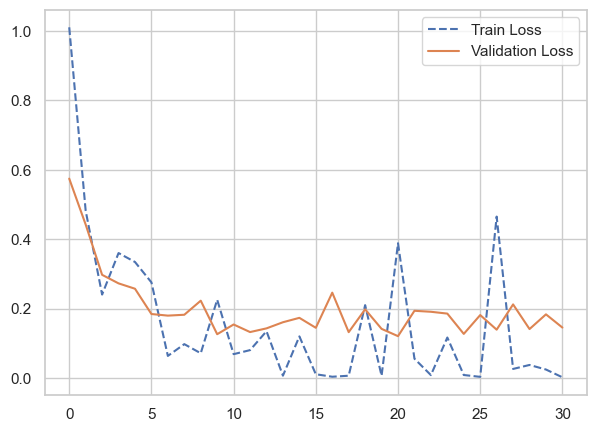

In [38]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [ ]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load best trained model

In [19]:
model_save_path = os.path.join(models_path, f"{model_name}_best_model.pth")
print(f"Loading {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading C:/Users/jrtervens/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models\MaxViT-Pretrained_best_model.pth


<All keys matched successfully>

In [ ]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

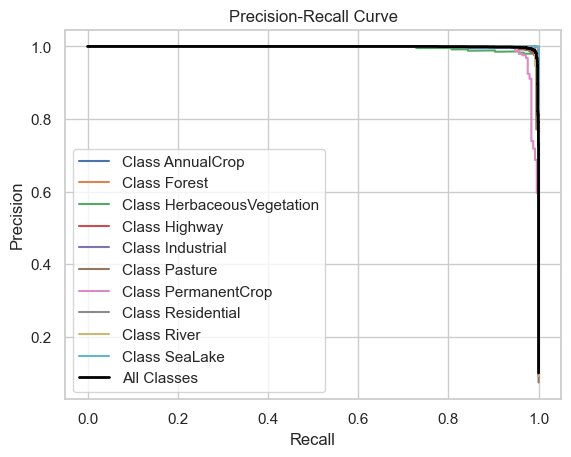

In [41]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [42]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▅▄▂▂▂▄▂▁▂▁▁▄▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▃▅▆▅▅▇▇▇▃▇▇▁▇▆█▇▇█▇████████████████████
val_loss,▃▄▃▁▂▂▁▁▁▅▁▂█▁▂▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃
epoch,41
step,25202
train_loss,0.0
val_accuracy,0.98963
val_loss,0.08774


In [43]:
del model2
torch.cuda.empty_cache()
gc.collect()

12385